### Simulation setup
TRAPPIST-1 planet data from Huang & Ormel (2022):
<center>
<img width=500 src="./Figures/trappist1_data.png"></img>
</center>

In [1]:
import rebound
import reboundx
import numpy as np
import matplotlib.pyplot as plt

# Create the simulation
sim = rebound.Simulation()
sim.units = ('AU', 'yr', 'Msun')
sim.integrator = "whfast"
sim.dt = 0.001  # small timestep, in years

# Add the star
sim.add(m=0.09)

# Define planet masses (converted to Msun), semi‐major axes (AU), and eccentricities
masses = np.array([1.374, 1.308, 0.388, 0.692, 1.039, 1.321, 0.326]) * 3.003e-6
a0 = np.array([1.154, 1.580, 2.227, 2.925, 3.849, 4.683, 6.189]) * 0.01
e0 = np.array([0.004, 0.002, 0.006, 0.0065, 0.009, 0.004, 0.0035])

# Add planets
for m, a, e in zip(masses, a0, e0):
    sim.add(m=m, a=a, e=e)

# Move to center of momentum
sim.move_to_com()

### Damping and forces

In [15]:
# Set up reboundx
rebx = reboundx.Extras(sim)

# --- Attach REBOUNDx and add the modify_orbits_forces effect ---
rebx = reboundx.Extras(sim)
mof = rebx.load_force("modify_orbits_forces")
rebx.add_force(mof)

# --- Damping timescales (in years) ---
tau_a_value = 20000.0            # semimajor axis timescale in years (example)
tau_e_value = tau_a_value / 100 # eccentricity damping (100x faster here)

# If you want damping, set negative timescales; positive would grow instead.
# Set per-particle parameters for the planets (skip star at index 0)
for p in sim.particles[1:]:
    p.params["tau_a"] = -tau_a_value
    p.params["tau_e"] = -tau_e_value
    # Optional: you can also set tau_i (inclination), or other params:
    # p.params["tau_i"] = -tau_e_value

### Integrate and Record

In [16]:
Noutputs = 2000
times = np.linspace(0, 1000, Noutputs)  # 1000 years
a_history = np.zeros((len(masses), Noutputs))

for i, t in enumerate(times):
    sim.integrate(t)
    for j, p in enumerate(sim.particles[1:]):  # skip the star
        a_history[j, i] = p.a

### Plotting

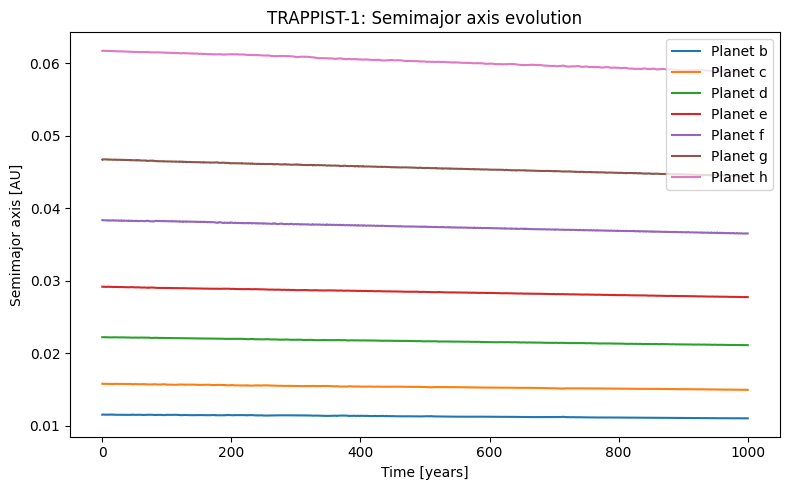

In [17]:
plt.figure(figsize=(8,5))
for j in range(len(masses)):
    plt.plot(times, a_history[j], label=f'Planet {chr(98+j)}')  # b, c, d, ...
plt.xlabel("Time [years]")
plt.ylabel("Semimajor axis [AU]")
plt.title("TRAPPIST-1: Semimajor axis evolution")
plt.legend()
plt.tight_layout()
plt.show()

### Damping parameters
$\tau_a$ is the semi-major axis damping timescale (i.e. migration timescale)
$\tau_e$ is the eccentricity damping timescale (usually $\dfrac{\tau_a}{K}$ with $K\approx 100$)

In [4]:
tau_a_value = 20000 # semiaxis damping
tau_e_value = tau_a_value / 100 # eccentricity damping
for p in sim.particles[1:]:
    # in simulation units
    rebx.parameters["tau_a"] = tau_a_value 
    rebx.parameters["tau_e"] = tau_e_value


AttributeError: 'Extras' object has no attribute 'parameters'

### Edge simulation
At the semi-major axis edge $a_{edge}$, the particle will experience 0 (or reversed) migration torque.

In [ ]:
def update_tau_a(sim_pointer):
    sim = sim_pointer.contents
    for p in sim.particles[1:]:
        if p.a < a_edge:
            rebx.parameters["tau_a"] = np.inf  # stop migration (cavity)
        elif p.a < a_edge + delta:
            rebx.parameters["tau_a"] = modified_value  # slow down
        else:
            rebx.parameters["tau_a"] = default_value
rebx.add_custom_hook(update_tau_a)


### Run and store results

In [ ]:
times = np.linspace(0, 1e5, 1000)
a_history = []
for t in times:
    sim.integrate(t)
    a_history.append([p.a for p in sim.particles[1:]])

### Check for resonance
Using the formula $(p+q)\lambda_2 - p\lambda_1 - q \varpi_1$.

### Calculating Laplace coefficients

In [ ]:
from pylaplace import LaplaceCoefficient

alpha = 0.9   # a1/a2
l = LaplaceCoefficient(alpha)
b_12_1 = l.b(1/2, 1)    # b_{1/2}^{(1)}(α)
b_32_2 = l.b(3/2, 2)    # b_{3/2}^{(2)}(α)
print(b_12_1, b_32_2)